<h1> Gaussian Mixture Model Fundamental</h1><br>
Author: gonsoomoon@gmail.com<br>
Date: May 20, 2018<br><br>
For understanding Gaussian Mixture Model (GMM) and EM (Expectation Maximization), the following code and examples are mostly reproduced by two references at the bottome of the reference section.

<h2> 1. Implementing Gaussian Mixtuer Model with EM Algorithm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [3]:
import pandas as pd
df = pd.read_csv("bimodal_example.csv")
df.shape # (100,1)
df.head()

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


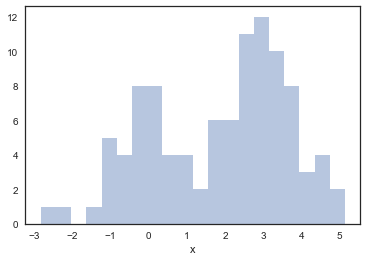

In [4]:
data = df.x
sns.distplot(data, bins=20, kde=False)

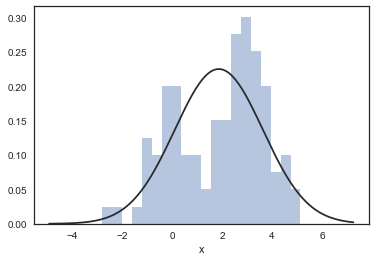

In [5]:
sns.distplot(data, fit = stats.norm, bins = 20, kde=False)

Define The Model
Two Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$.
There are 5 paramaters: 4 of the them are Normal distributions and 1 more for the probability of choosing one of them.
Let $w$ be the probability that the data comes from the first Normal, the parameter in this model is $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$.
The probability density function (PDF) is:
$$f(x | \theta) = w \  f_1(x \ | \  \mu_1, \sigma_1^2) + (1 - w) \  f_2 (x  \ | \  \mu_2, \sigma_2^2) $$

EM is tyring to maximize the following functions: <br>
* X is directly observed variable
* _theta parameters of model
* Z is not directly observed / latent variable
- Z is a joint (related) distribution on x.

EM steps, stated another way <br>
1. Initialize the parameters of the models, either randomly or doing a 'smart seeding'
2. E Step: Find the posterior probabilities [f(x|theta)] of the latent variable given current parameter values
3. M Step: Reestimate the parameter values given the current posterior probabilities.
4. Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence

In [16]:
import math
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    #probability density function
    def pdf(self, x):
        mu = self.mu
        sig = self.sigma
        return 1./(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
    # printing model values
    #def __repr__(self): 
    #    return 'Gaussian({0:4.6}, {1:4.6})'.format(best_single.mu, best_single.sigma)
    def __repr__(self): 
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [20]:
# gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print(best_single)
#print('Best single Gaussian: mu = {:.2}, sigma={:.2}'.format(best_single.mu, best_single.sigma))

Gaussian(1.86285, 1.77022)


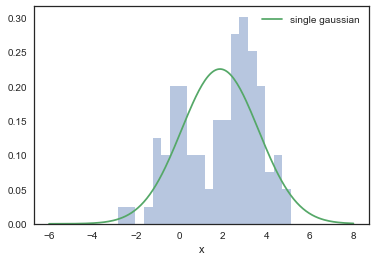

In [23]:
# fit a single gaussian curve to the data
x = np.linspace(-6,8,200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend()

In [86]:
from math import sqrt, log, exp, pi
from random import uniform

class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"
    def __init__(self, data, mu_min = min(data),
                mu_max=max(data), sigma_min=.1, sigma_max=1,
                mix = .5):
        self.data = data
        # init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max),
                           uniform(sigma_min, sigma_max))
        # as well as how much to mix them
        self.mix = mix
        
    def Estep(self):
        "Perform an E(estimation)-step, freshing up self.loglike in the process"
        # compute weights
        self.loglike = 0. # log(p=1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 = wp1 / den
            wp2 = wp2 / den
            # add into loglike
            self.loglike = self.loglike + log(wp1 + wp2)
            #print(self.loglike, " ", log(wp1 + wp2))
            
            # yield weight tuple
            yield (wp1, wp2)
            
    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        # compute new means
        self.one.mu = sum(w*d / one_den for (w,d) in zip(left, data))
        self.two.mu = sum(w*d / two_den for (w,d) in zip(right, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) **2)
                                 for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) **2)
                                 for (w, d) in zip(right, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)
        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(N):
            weights = self.Estep()
            self.Mstep(weights)
            print(self.__str__())
    
    def pdf(self, x):
        return (self.mix) * self.one.pdf(x) + (1-self.mix) * self.two.pdf(x)
    def __repr__(self):
        return "GaussianMixture({0}, {1}, mix = {2.03})".format(self.one, self.two, self.mix)        
    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03}'.format( self.one, self.two, self.mix)  
        

In [122]:
# draw original data and gmm mixture 
def draw_gmm(x, data, mix):
    sns.distplot(data, bins=20, kde=False, norm_hist=True)
    g_both = [mix.pdf(e) for e in x]
    plt.plot(x, g_both, label = 'gaussian mixture');
    plt.legend();   
    print("Log like: ", mix.loglike)


<h3> Examples of making gmm with an initial random values</h3>

Mixture: Gaussian(2.11576, 1.76457), Gaussian(0.206895, 0.321326), mix=0.868
-5.551115123125783e-16


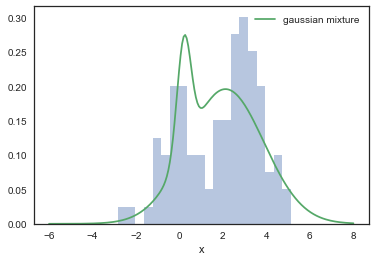

In [117]:
mix = GaussianMixture(data)
mix.iterate()
# mixture
draw_gmm(x, data, mix)

Mixture: Gaussian(2.93658, 0.925349), Gaussian(-0.332854, 0.782342), mix=0.672
-1.1102230246251568e-16


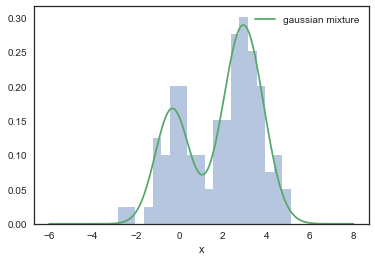

In [118]:
mix = GaussianMixture(data)
mix.iterate()
# mixture
draw_gmm(x, data, mix)

Mixture: Gaussian(3.23987, 0.433278), Gaussian(1.48776, 1.81078), mix=0.214
-1.5543122344752192e-15


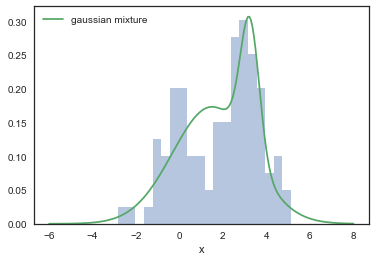

In [119]:
mix = GaussianMixture(data)
mix.iterate()
# mixture
draw_gmm(x, data, mix)

In [120]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                print("mix.loglike: ", mix.loglike)
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...

Mixture: Gaussian(3.77085, 0.386246), Gaussian(1.37058, 1.64987), mix=0.205
mix.loglike:  -5.551115123125783e-16
Mixture: Gaussian(3.64884, 0.447528), Gaussian(1.46696, 1.70883), mix=0.181
Mixture: Gaussian(3.54555, 0.474577), Gaussian(1.48788, 1.73499), mix=0.182
Mixture: Gaussian(3.46196, 0.487972), Gaussian(1.48521, 1.75242), mix=0.191
Mixture: Gaussian(3.39558, 0.496774), Gaussian(1.47251, 1.76585), mix=0.203
Mixture: Gaussian(3.3433, 0.505184), Gaussian(1.45516, 1.77667), mix=0.216
Mixture: Gaussian(3.3023, 0.514837), Gaussian(1.43562, 1.78538), mix=0.229
Mixture: Gaussian(3.27036, 0.526018), Gaussian(1.41498, 1.79214), mix=0.241
Mixture: Gaussian(3.24582, 0.538433), Gaussian(1.39366, 1.79706), mix=0.253
Mixture: Gaussian(3.22744, 0.551648), Gaussian(1.37177, 1.80016), mix=0.265
Mixture: Gaussian(3.21424, 0.565296), Gaussian(1.3493, 1.80148), mix=0.275
Mixture: Gaussian(3.20541, 0.579131), Gaussian(1.32621, 1.80103), mix=0.286
Mixture:

/Users/gonsoomoon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/gonsoomoon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


Mixture: Gaussian(2.45985, 0.341835), Gaussian(1.78939, 1.85893), mix=0.11
Mixture: Gaussian(2.53336, 0.347217), Gaussian(1.78643, 1.84932), mix=0.102
Mixture: Gaussian(2.59946, 0.357696), Gaussian(1.78039, 1.84462), mix=0.101
Mixture: Gaussian(2.6645, 0.373971), Gaussian(1.77076, 1.84263), mix=0.103
Mixture: Gaussian(2.73343, 0.395173), Gaussian(1.75617, 1.84235), mix=0.109
Mixture: Gaussian(2.8081, 0.418299), Gaussian(1.73469, 1.84316), mix=0.119
Mixture: Gaussian(2.88523, 0.439149), Gaussian(1.70471, 1.84441), mix=0.134
Mixture: Gaussian(2.95772, 0.455087), Gaussian(1.66634, 1.84531), mix=0.152
Mixture: Gaussian(3.01913, 0.466566), Gaussian(1.622, 1.84515), mix=0.172
Mixture: Gaussian(3.06676, 0.475794), Gaussian(1.57576, 1.84361), mix=0.193
Mixture: Gaussian(3.10128, 0.484803), Gaussian(1.53161, 1.84093), mix=0.211
Mixture: Gaussian(3.12505, 0.4947), Gaussian(1.49202, 1.83762), mix=0.227
Mixture: Gaussian(3.14082, 0.505797), Gaussian(1.45761, 1.83415), mix=0.241
Mixture: Gaussian(3

Log like:  8.881784197001251e-16


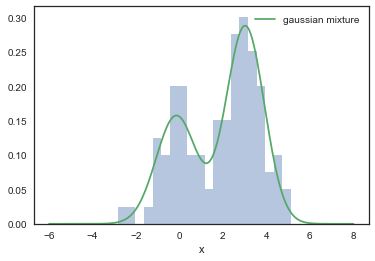

In [123]:
draw_gmm(x, data, best_mix)
# Best Mixture: Gaussian(3.02426, 0.876282), Gaussian(-0.143178, 0.93057), mix=0.633


<h2> 2. Non-circular GMM </h2>

In [124]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

[[-0.71239066  0.75376638]
 [-0.04450308  0.45181234]]


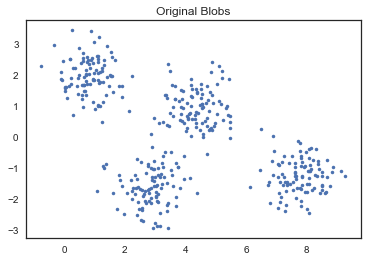

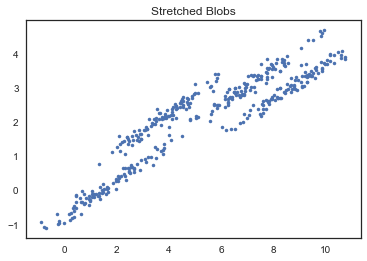

In [125]:
rng = np.random.RandomState(13)
print(rng.randn(2,2))
X_stretched = np.dot(X, rng.randn(2,2))
#print(X_stretched)
plt.title("Original Blobs")
plt.plot(X[:,0],X[:,1], marker='.', linestyle='none' )
plt.show()
plt.title("Stretched Blobs")
plt.plot(X_stretched[:,0],X_stretched[:,1], marker='.', linestyle='none' )
plt.show()

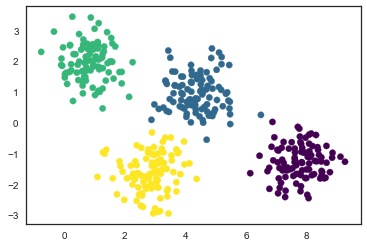

In [126]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis')

In [127]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


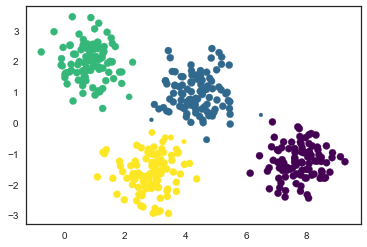

In [128]:
size = 50* probs.max(1) ** 2 # square emphasizes difference
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=size)

In [129]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    # Draw an ellipse with a given position and covariance

    ax = ax or plt.gca()
    
    print("position: ", position)
    print("covariance: \n", covariance)
    
    # Convert covariance to principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2 * np.sqrt(s)
        print("U: ", U)
        print("s: ", s)
        print("Vt: ", Vt)
        print("angle: ", angle)
        print("width: ", width, " height: ", height)
        print("\n")
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label = True, ax = None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap = 'viridis', zorder=2)
    else:
        ax.scatter(X[:,0], X[:,1], s= 40, zorder = 2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)
        



position:  [4.36221851 0.93141671]
covariance: 
 [[ 0.40398685 -0.00235346]
 [-0.00235346  0.36933794]]
U:  [[-0.99772208  0.06745858]
 [ 0.06745858  0.99772208]]
s:  [0.40414598 0.36917882]
Vt:  [[-0.99772208  0.06745858]
 [ 0.06745858  0.99772208]]
angle:  176.1319706047611
width:  1.2714495271356179  height:  1.2152017421436023


position:  [0.83760086 1.9579654 ]
covariance: 
 [[ 0.29768676 -0.02444193]
 [-0.02444193  0.34173529]]
U:  [[-0.40656478  0.91362196]
 [ 0.91362196  0.40656478]]
s:  [0.35261203 0.28681002]
Vt:  [[-0.40656478  0.91362196]
 [ 0.91362196  0.40656478]]
angle:  113.98922168493918
width:  1.1876228900649857  height:  1.071092941512502


position:  [ 7.76222624 -1.27635633]
covariance: 
 [[0.36530305 0.01293533]
 [0.01293533 0.28921965]]
U:  [[-0.98660124 -0.16315024]
 [-0.16315024  0.98660124]]
s:  [0.36744211 0.28708059]
Vt:  [[-0.98660124 -0.16315024]
 [-0.16315024  0.98660124]]
angle:  -170.61020492186654
width:  1.2123400722959166  height:  1.07159803901081

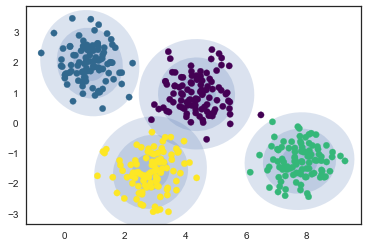

In [130]:
gmm = GaussianMixture(n_components =4, random_state = 42)
plot_gmm(gmm, X)



position:  [7.12609191 3.12408539]
covariance: 
 [[1.40799919 0.71828727]
 [0.71828727 0.38752591]]
U:  [[-0.8885698  -0.45874144]
 [-0.45874144  0.8885698 ]]
s:  [1.77882897 0.01669613]
Vt:  [[-0.8885698  -0.45874144]
 [-0.45874144  0.8885698 ]]
angle:  -152.69407508687155
width:  2.6674549416402575  height:  0.2584270473498802


position:  [1.62581141 0.11095536]
covariance: 
 [[1.4736701  0.75963054]
 [0.75963054 0.41028365]]
U:  [[-0.88696885 -0.46182925]
 [-0.46182925  0.88696885]]
s:  [1.8691965  0.01475725]
Vt:  [[-0.88696885 -0.46182925]
 [-0.46182925  0.88696885]]
angle:  -152.49479131903988
width:  2.7343712257637085  height:  0.24295881182899348


position:  [3.76995847 2.13214542]
covariance: 
 [[1.07298223 0.56483074]
 [0.56483074 0.31549068]]
U:  [[-0.88230653 -0.47067525]
 [-0.47067525  0.88230653]]
s:  [1.37429684 0.01417607]
Vt:  [[-0.88230653 -0.47067525]
 [-0.47067525  0.88230653]]
angle:  -151.92186285207046
width:  2.344608143330763  height:  0.23812657498075876




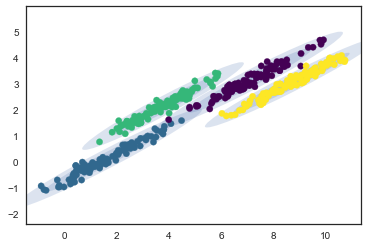

In [131]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state = 42)
plot_gmm(gmm, X_stretched)

<h2>3. GMM as a Density Estimation</h2>

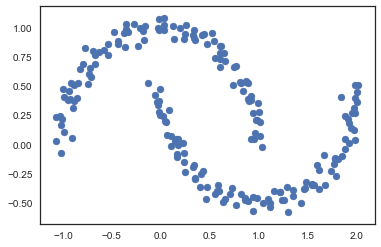

In [132]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

position:  [-0.14655377  0.63648337]
covariance: 
 [[0.35020469 0.05044723]
 [0.05044723 0.09580468]]
U:  [[-0.98223298 -0.18766558]
 [-0.18766558  0.98223298]]
s:  [0.35984314 0.08616622]
Vt:  [[-0.98223298 -0.18766558]
 [-0.18766558  0.98223298]]
angle:  -169.18341835864052
width:  1.1997385447896054  height:  0.5870816779228262


position:  [ 1.13342753 -0.12841187]
covariance: 
 [[0.35025062 0.04830866]
 [0.04830866 0.09907425]]
U:  [[-0.98319171 -0.18257619]
 [-0.18257619  0.98319171]]
s:  [0.35922142 0.09010346]
Vt:  [[-0.98319171 -0.18257619]
 [-0.18257619  0.98319171]]
angle:  -169.48014849608776
width:  1.1987016616815314  height:  0.6003447531527929




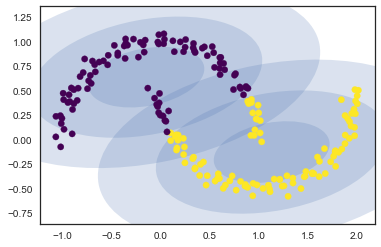

In [133]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

position:  [-0.85012528  0.50300244]
covariance: 
 [[0.01359769 0.01428541]
 [0.01428541 0.02158577]]
U:  [[-0.60445744 -0.79663743]
 [-0.79663743  0.60445744]]
s:  [0.03242498 0.00275848]
Vt:  [[-0.60445744 -0.79663743]
 [-0.79663743  0.60445744]]
angle:  -127.18981004326042
width:  0.36013877643470615  height:  0.10504241684453998


position:  [ 0.58056811 -0.38663301]
covariance: 
 [[ 0.01170574 -0.0009856 ]
 [-0.0009856   0.00065096]]
U:  [[-0.99611034  0.08811468]
 [ 0.08811468  0.99611034]]
s:  [0.01179293 0.00056377]
Vt:  [[-0.99611034  0.08811468]
 [ 0.08811468  0.99611034]]
angle:  174.9448447233443
width:  0.21719048215311454  height:  0.04748776716087273


position:  [0.75008629 0.60482693]
covariance: 
 [[ 0.02146376 -0.02400446]
 [-0.02400446  0.03082268]]
U:  [[-0.63586968  0.77179644]
 [ 0.77179644  0.63586968]]
s:  [0.05059954 0.00168691]
Vt:  [[-0.63586968  0.77179644]
 [ 0.77179644  0.63586968]]
angle:  129.48451715844297
width:  0.4498868129391027  height:  0.0821440

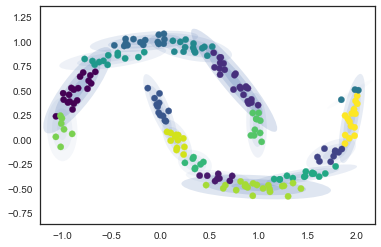

In [134]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)

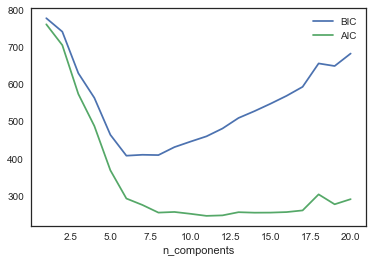

In [135]:
# Choose the best numboer of components
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

position:  [-0.84497415  0.47216279]
covariance: 
 [[0.02362719 0.03320328]
 [0.03320328 0.06334075]]
U:  [[-0.49332731 -0.86984376]
 [-0.86984376  0.49332731]]
s:  [0.08217181 0.00479613]
Vt:  [[-0.49332731 -0.86984376]
 [-0.86984376  0.49332731]]
angle:  -119.55951168755094
width:  0.5733125220871317  height:  0.13850812858257489


position:  [ 1.03417022 -0.44109815]
covariance: 
 [[0.10319563 0.00292334]
 [0.00292334 0.00397346]]
U:  [[-0.99956701 -0.02942432]
 [-0.02942432  0.99956701]]
s:  [0.10328169 0.00388741]
Vt:  [[-0.99956701 -0.02942432]
 [-0.02942432  0.99956701]]
angle:  -178.31386719538443
width:  0.6427493689579697  height:  0.12469812483170897


position:  [0.8141197  0.47329677]
covariance: 
 [[ 0.02760124 -0.04092794]
 [-0.04092794  0.07246241]]
U:  [[-0.50960483  0.86040858]
 [ 0.86040858  0.50960483]]
s:  [0.0967033  0.00336034]
Vt:  [[-0.50960483  0.86040858]
 [ 0.86040858  0.50960483]]
angle:  120.63751103228083
width:  0.6219430932804386  height:  0.11593689352

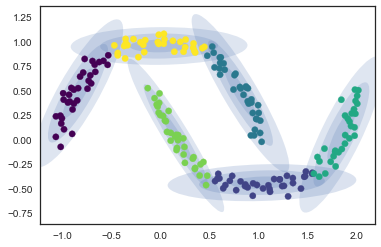

In [136]:
gmm6 = GaussianMixture(n_components=6, covariance_type='full', random_state=0)
plot_gmm(gmm6, Xmoon)

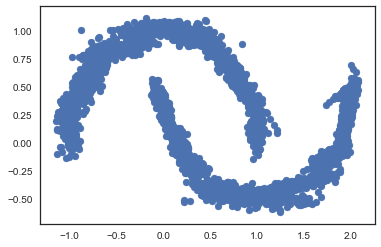

In [138]:
Xnew = gmm16.sample(4000)
x, y = Xnew
#print(x)

plt.scatter(x[:,0], x[:, 1]);

<h2>4. Sampling from GMM</h2><br>
1) Load digits image (1797 * 64)<br>
2) PCA Dimension Reduction (64 to 41), covering 99% variance<br>
3) Find the best number of components of GMM using AIC<br>
4) Find 110 and fit data with GMM by 110 components <br>
5) Sample from the GMM on 4)<br>
6) Inverse the sample, from 41 to 64, using PCA.inverse_transform<br>
7) Draw the sample image

In [139]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

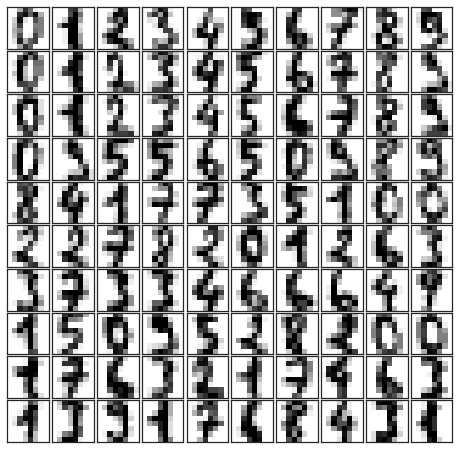

In [140]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [141]:
# Change 64 to 41 dimensions by PCA, covering 99% variance
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

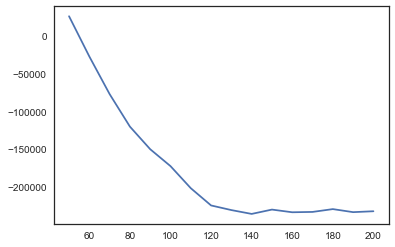

In [142]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [143]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [144]:
data_new = gmm.sample(100)
x, y = data_new
#print(data_new)

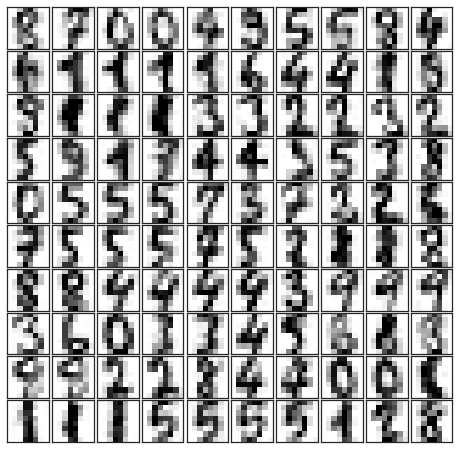

In [145]:
digits_new = pca.inverse_transform(x)
plot_digits(digits_new)

<h2>Reference</h2><br>
[1]  Siraj Raval. Gaussian Mixture Models - Predicting Customer Churn, https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb (2017) <br>
[2] Jake VanderPlas.In Depth: Gaussian Mixture Models. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html. Python Data Science Handbook (2016) 